<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flower_Recognition_Challenges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Flowers Recognition**
It is a dataset from kaggle and I will implement some of the best notebooks and compare them to learn the best pattern to solve this problem.
you can access the dataset or the notebooks in [here](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, metrics

###Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

In [5]:
path_folder = '/content/flowers'

size = 224
data = []
label = []
data_names = []
id = 0
for folder in os.listdir(path_folder):
  for files in os.listdir(os.path.join(path_folder, folder)):
    if files.endswith('jpg'):
      label.append(folder)
      img_path = os.path.join(path_folder, folder, files)
      data_names.append((id, img_path))
      img = cv2.imread(img_path)
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      im = cv2.resize(img_rgb, (size, size))
      data.append(im)
      id += 1
    else:
      continue

In [6]:
set(label), len(label)

({'daisy', 'dandelion', 'rose', 'sunflower', 'tulip'}, 4317)

In [7]:
np.array(data).shape

(4317, 224, 224, 3)

In [8]:
data = np.array(data)
label = np.array(label)

In [9]:
x = data/255
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(label)
y = tf.keras.utils.to_categorical(y)

Creating test, train data from x, will consume all them memory we have in colab,
so instead we can put **data_names** in to train/test splits.


In [10]:
# x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=32, test_size=0.2)

x_train, x_test, y_train, y_test = model_selection.train_test_split(data_names, y, random_state=32, test_size=0.2)

In [11]:
len(x_train), len(x_test)

(3453, 864)

In [12]:
x_train[:20]

[(270, '/content/flowers/dandelion/4610125337_50798408b8_m.jpg'),
 (3088, '/content/flowers/daisy/2578695910_5ab8ee17c1_n.jpg'),
 (3784, '/content/flowers/sunflower/1043442695_4556c4c13d_n.jpg'),
 (238, '/content/flowers/dandelion/34690479536_69da7b98e7_n.jpg'),
 (1325, '/content/flowers/rose/26811158051_8f264eea6b_n.jpg'),
 (3828, '/content/flowers/sunflower/3568925290_faf7aec3a0.jpg'),
 (3313, '/content/flowers/daisy/34476770012_38fba290f3_n.jpg'),
 (911, '/content/flowers/dandelion/2330339852_fbbdeb7306_n.jpg'),
 (4228, '/content/flowers/sunflower/14678298676_6db8831ee6_m.jpg'),
 (8, '/content/flowers/dandelion/7267547016_c8903920bf.jpg'),
 (3030, '/content/flowers/daisy/144076848_57e1d662e3_m.jpg'),
 (593, '/content/flowers/dandelion/6901435398_b3192ff7f8_m.jpg'),
 (3547, '/content/flowers/daisy/2838487505_6c3b48efa5_m.jpg'),
 (464, '/content/flowers/dandelion/17322195031_c2680809dc_m.jpg'),
 (1564, '/content/flowers/rose/12406229175_82e2ac649c_n.jpg'),
 (2783, '/content/flowers/tu

# 1.CNN Architectures : VGG, ResNet, Inception + TL
[Note Book](https://www.kaggle.com/code/shivamb/cnn-architectures-vgg-resnet-inception-tl)

##1.1 VGG16
####Visual Geometry Group from Oxford
VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals

###From Scratch VGG16

In [39]:
class VGG16(tf.keras.models.Model):
  def __init__(self):
    super(VGG16, self).__init__()

    #1
    self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='block1_conv1')
    self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='block1_conv2')
    self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    #2
    self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='block2_conv1')
    self.conv4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name='block2_conv2')
    self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    #3
    self.conv5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_conv1')
    self.conv6 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_conv2')
    self.conv7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name='block3_conv3')
    self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    #4
    self.conv8 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_conv1')
    self.conv9 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_conv2')
    self.conv10 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block4_conv3')
    self.maxpool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    #5
    self.conv11 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_conv1')
    self.conv12 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_conv2')
    self.conv13 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block5_conv3')
    self.maxpool5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    #6
    self.flat = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(4096, activation='relu', name='fc1')
    self.droput1 = tf.keras.layers.Dropout(rate=0.5, name='Dropout1')
    self.dense2 = tf.keras.layers.Dense(4096, activation='relu', name='fc2')
    self.droput2 = tf.keras.layers.Dropout(rate=0.5, name='Dropout2')
    self.dense3 = tf.keras.layers.Dense(1000, activation='softmax', name='fc2')


  def call(self, inputs):
    # inputs = tf.keras.Input(shape=(224, 224, 1))
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.maxpool1(x)

    x = self.conv3(x)
    x = self.conv4(x)
    x = self.maxpool2(x)

    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.maxpool3(x)

    x = self.conv8(x)
    x = self.conv9(x)
    x = self.conv10(x)
    x = self.maxpool4(x)

    x = self.conv11(x)
    x = self.conv12(x)
    x = self.conv13(x)
    x = self.maxpool5(x)
    
    x = self.flat(x)

    x = self.dense1(x)
    x = self.droput1(x)

    x = self.dense2(x)
    x = self.droput2(x)

    x = self.dense3(x)

    return x

###Pretrained VGG16 Weights

In [14]:
test_imgs = np.array([x[1], x[2], x[3], x[4]])

In [15]:
def image_loader(img_path, t_size=224):
  img = Image.image.load_img(img_path, target_size=(t_size, t_size))
  img = Image.image.img_to_array(img)
  img = np.expand_dim(img, axis=0)
  img = tf.keras.applications.vgg16.preprocess_input(img)
  return img

In [16]:
def predict_img(imgs, model):
  fig, ax = plt.subplots(1, 4)
  fig.set_size_inches(80, 40)
  for i in range(4):
    ax[i].imshow(Image.open(imgs[i][1]).resize((200, 200), Image.ANTIALIAS))
    plt.show()
  
  fig, ax = plt.subplots(1, 4)
  fig.set_size_inches(80, 20)
  for i, img_path in enumerate(imgs):
    img = image_loader(img_path[1])
    preds = tf.keras.applications.vgg16.decode_predictions(model.pedict(img), top=3)[0]
    b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color='gray', ax=ax[i])
    b.tick_params(labelsize=55)
    fig.tighy_layout()

In [ ]:
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

In [42]:
vgg16_model = VGG16()
vgg16_model.build(input_shape=(1, 224, 224, 3))
vgg16_model.summary()

Model: "vgg16_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       multiple                  1792      
                                                                 
 block1_conv2 (Conv2D)       multiple                  36928     
                                                                 
 max_pooling2d_90 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 block2_conv1 (Conv2D)       multiple                  73856     
                                                                 
 block2_conv2 (Conv2D)       multiple                  147584    
                                                                 
 max_pooling2d_91 (MaxPoolin  multiple                 0         
 g2D)                                                     

In [43]:
vgg16_weights = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5')

TypeError: ignored

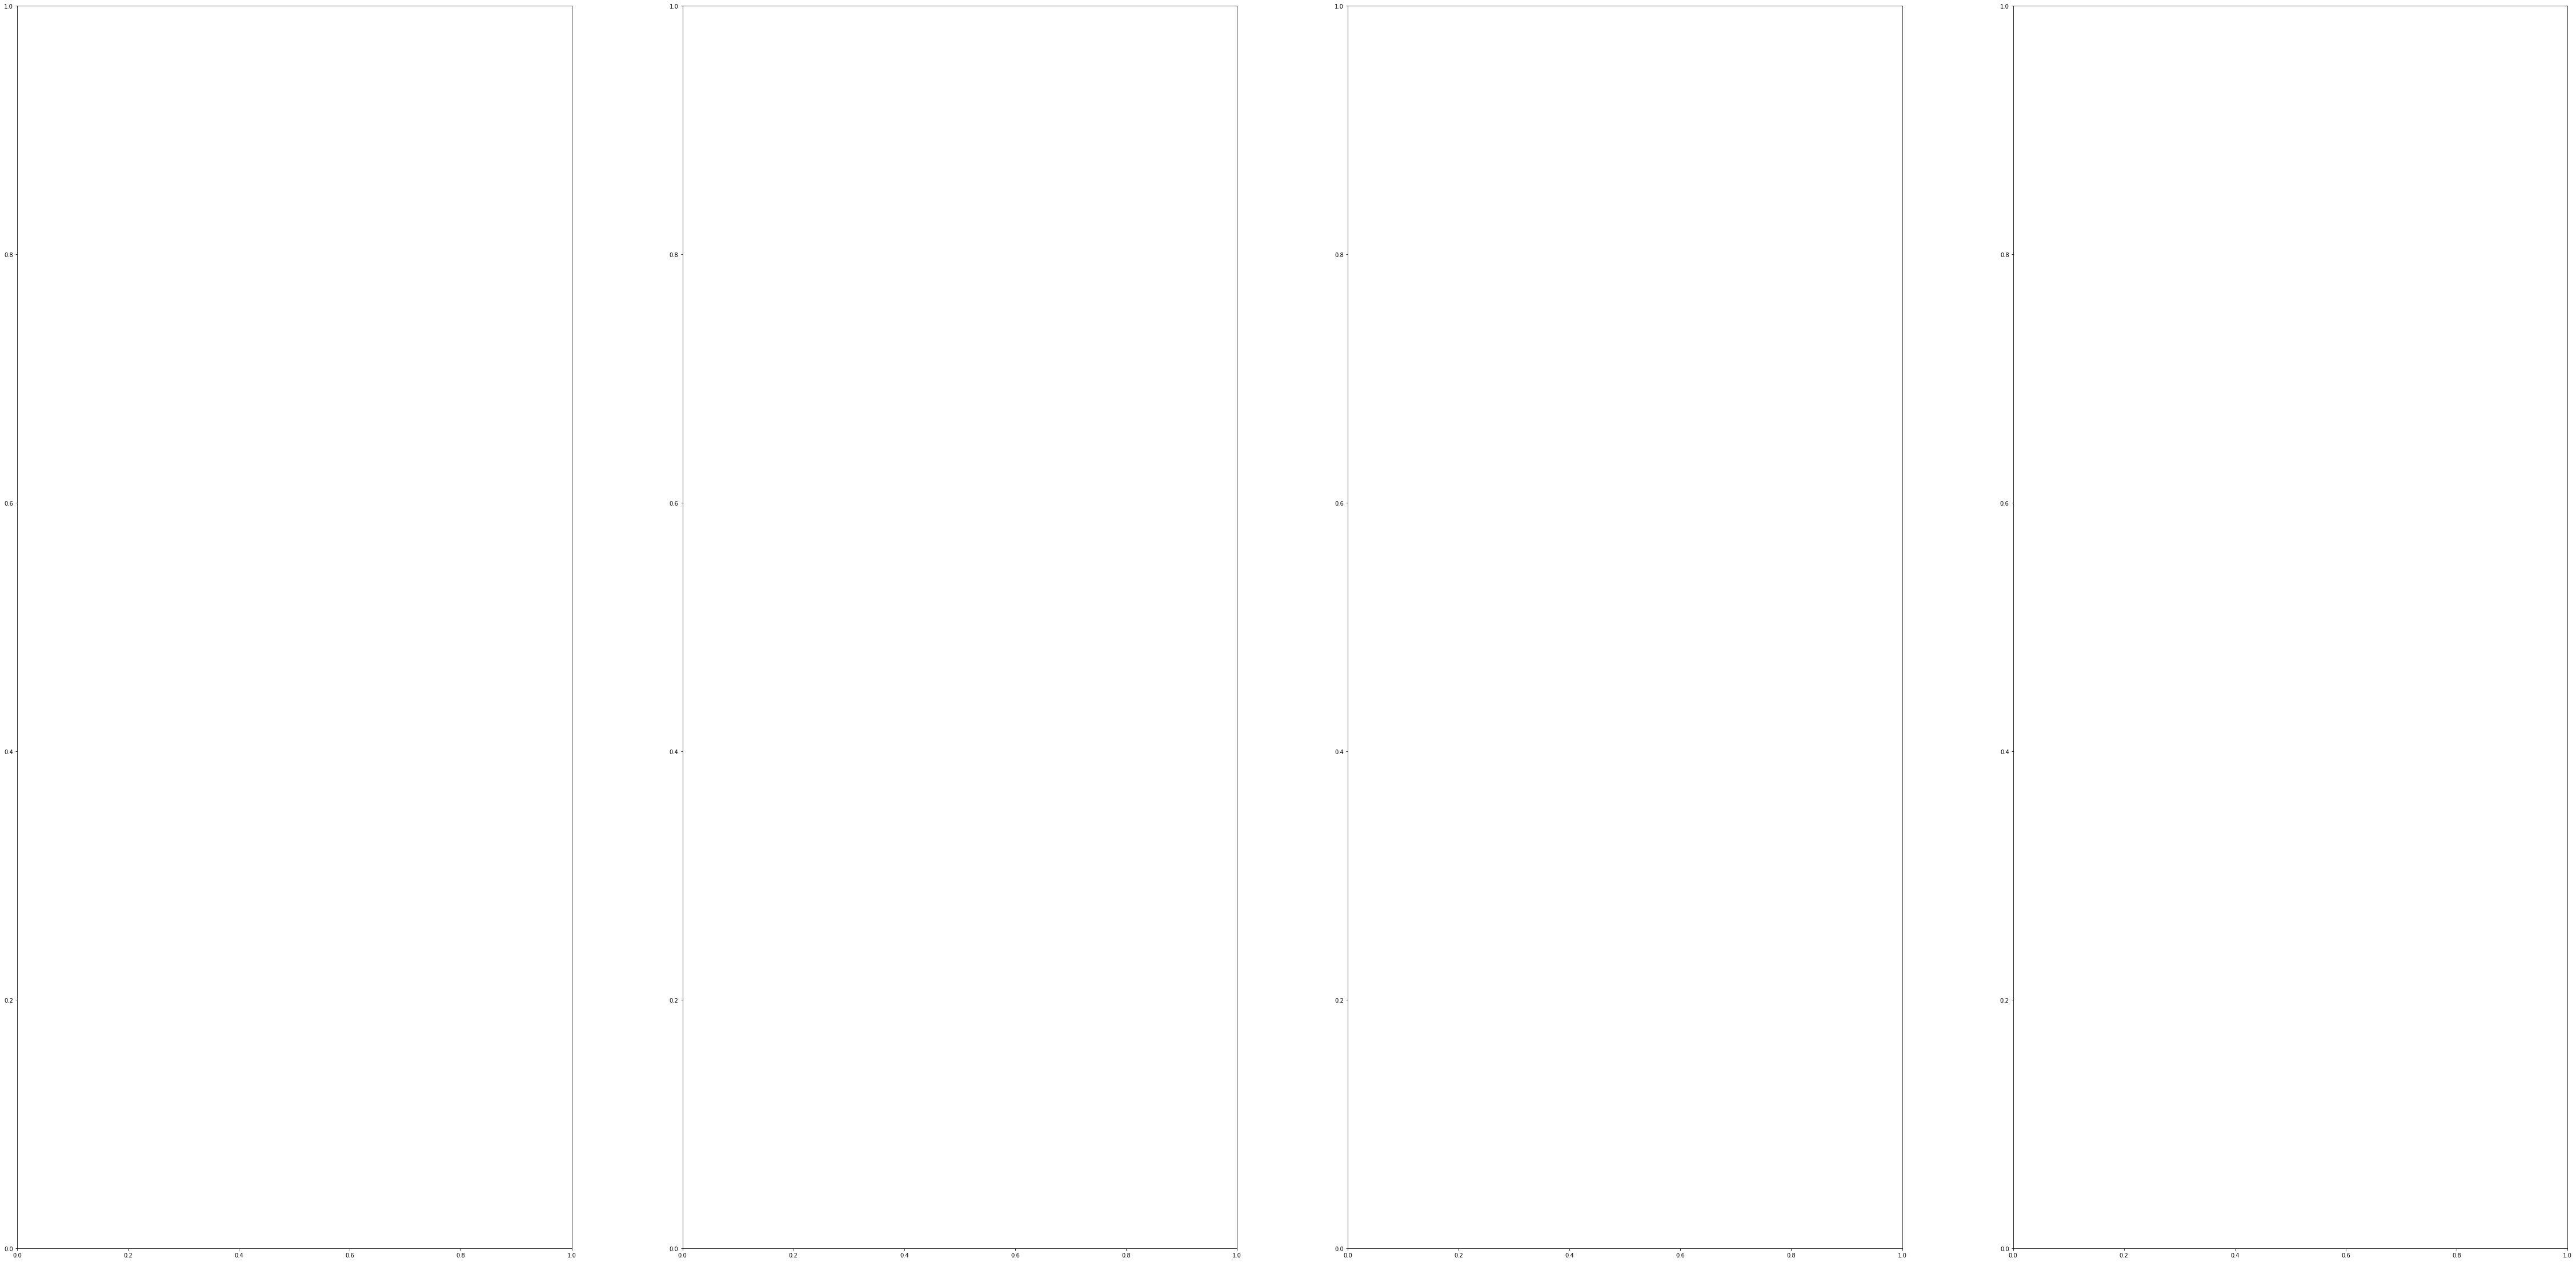

In [44]:
predict_img(vgg16_model, test_imgs)